In [1]:
import sys
sys.path.append("..")
from flame_analysis_model import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.empty_cache()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import torch.nn.functional as F


In [2]:
features = [
    'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
    'omega_HO2', 'omega_H2O2', 'omega_N2'
]

time_step = 212
phi = 0.40
lat_size = 100

df = pd.read_csv(f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref/extracted_flame_front_{time_step}.csv")

colourmap = df["disp_speed_density_weighted"]
X = StandardScaler().fit_transform(df[features])

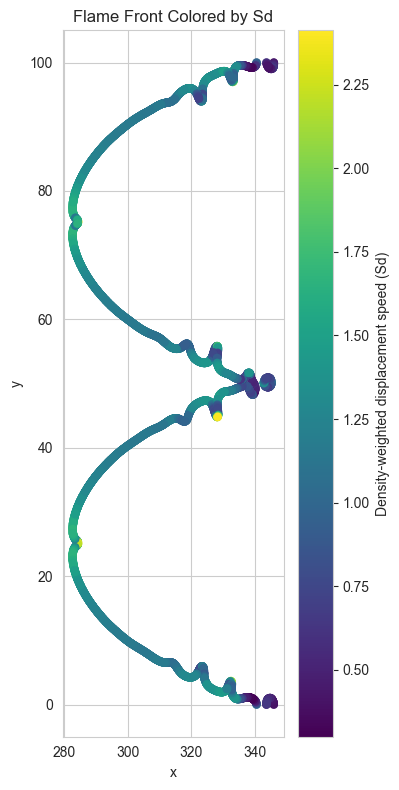

In [3]:
plt.figure(figsize=(4, 8))

sc = plt.scatter(
    df["x"],
    df["y"],
    c = df["disp_speed_density_weighted"],
    cmap = "viridis",
    linewidths = 0.1
)


plt.colorbar(sc, label="Density-weighted displacement speed (Sd)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Flame Front Colored by Sd")
plt.tight_layout()
plt.show()

## Vanilla PCA

In [23]:
pca = PCA()
X_pca= pca.fit(X)

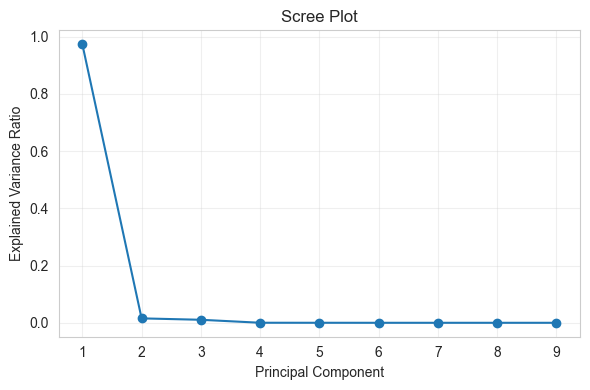

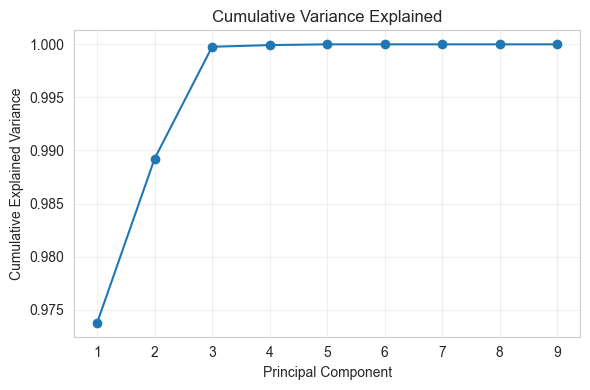

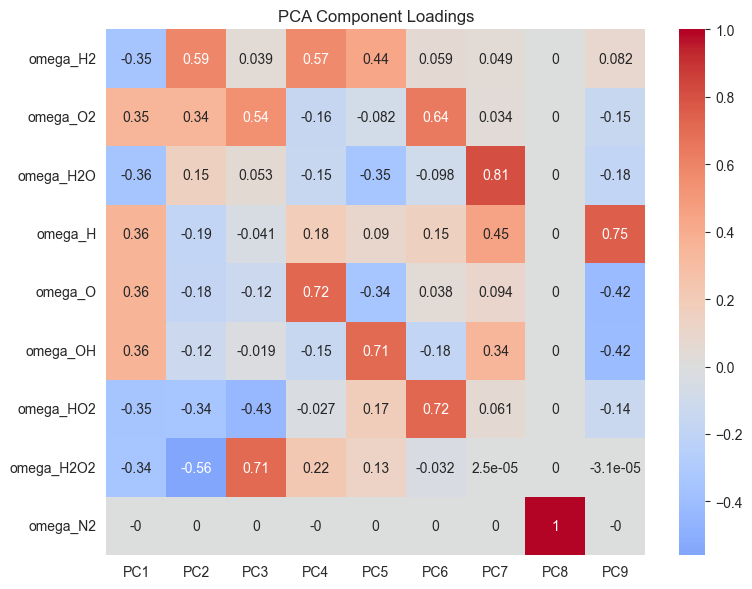

In [24]:
# PCA COMPONENT PLOTS
# ============================================================

# 1. Scree plot — explained variance per PC
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_,
         marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Cumulative explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_),
         marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Variance Explained")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Loadings heatmap (feature contributions to each PC)
loadings = pd.DataFrame(
    pca.components_.T,
    index=features,
    columns=[f"PC{i + 1}" for i in range(len(features))]
)

plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Component Loadings")
plt.tight_layout()
plt.show()


## Kernel PCA

In [25]:
kpca = KernelPCA()
kpca.fit(X)

,n_components,None
,kernel,'linear'
,gamma,None
,degree,3
,coef0,1
,kernel_params,None
,alpha,1.0
,fit_inverse_transform,False
,eigen_solver,'auto'
,tol,0
,max_iter,None


Number of Eigenvalues: 6


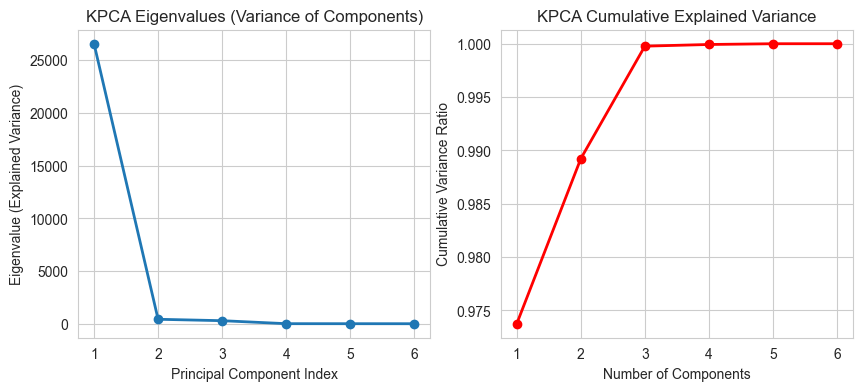

In [26]:
# PCA COMPONENT PLOTS
# ============================================================
# Get the eigenvalues (variance explained by components in feature space)
eigvals = kpca.eigenvalues_
print(f"Number of Eigenvalues: {len(eigvals)}")

# Plotting the eigenvalues (Scree Plot for KPCA)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(eigvals) + 1), eigvals, 'o-', linewidth=2)
plt.title('KPCA Eigenvalues (Variance of Components)')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.grid(True)

# Plotting the cumulative explained variance (optional but helpful)
cumulative_variance = np.cumsum(eigvals) / np.sum(eigvals)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(eigvals) + 1), cumulative_variance, 'o-', linewidth=2, color='red')
plt.title('KPCA Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Ratio')
plt.grid(True)
plt.show()



## Sparce PCA

## LVR-AE

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


Epoch 1000: rec = 0.0096734, vol = 0.06082
Epoch 2000: rec = 0.0026317, vol = 0.10083
Epoch 3000: rec = 0.0010064, vol = 0.051965
Epoch 4000: rec = 0.00018992, vol = 0.054855
Epoch 5000: rec = 0.0001885, vol = 0.055699
Epoch 6000: rec = 0.00018538, vol = 0.045764


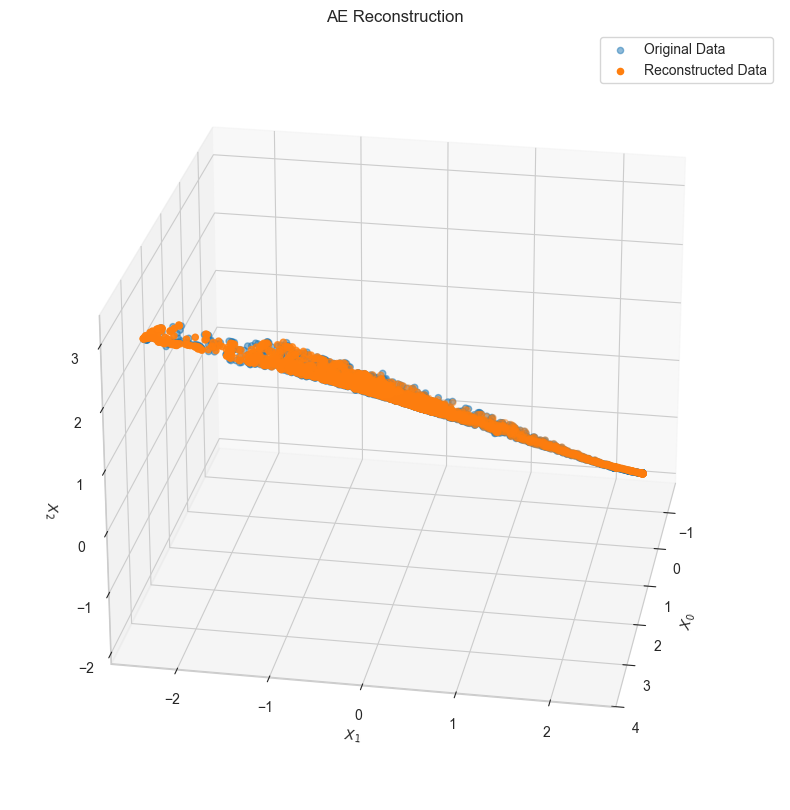

In [28]:

# Move data to GPU
ambient_dim = X.shape[1]
X_torch = torch.from_numpy(X).float().to(device)

width = ambient_dim * 16
# Define models and move to GPU
encoder = MLP(ambient_dim, ambient_dim, [width] * 4).to(device)
decoder = SNMLP(ambient_dim, ambient_dim, [width] * 4).to(device)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

eta, l = 0.01, 0.01

for i in range(6000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    vol_loss = torch.exp(torch.log(z.std(0) + eta).mean())
    loss = rec_loss + l * vol_loss
    loss.backward()
    opt.step()

    if (i + 1) % 1000 == 0:
        print(f'Epoch {i + 1:4}: rec = {rec_loss.item():.5g}, vol = {vol_loss.item():.5g}')

# Move data back to CPU for plotting
encoder.eval()
decoder.eval()
with torch.no_grad():
    X_P = decoder(encoder(X_torch)).cpu().numpy()

X_np = X_torch.cpu().numpy()

# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], alpha=0.5)
ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev = 25
ax.azim = 10
plt.legend(['Original Data', 'Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()
# Switch to eval mode and disable gradient tracking
encoder.eval()
decoder.eval()
with torch.no_grad():
    z = encoder(X_torch)

# Move latent vectors to CPU once and convert to NumPy
z_np = z.detach().cpu().numpy()

# Rank dimensions by standard deviation (importance)
idx = z.std(0).argsort(descending=True)



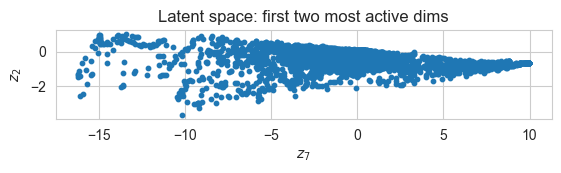

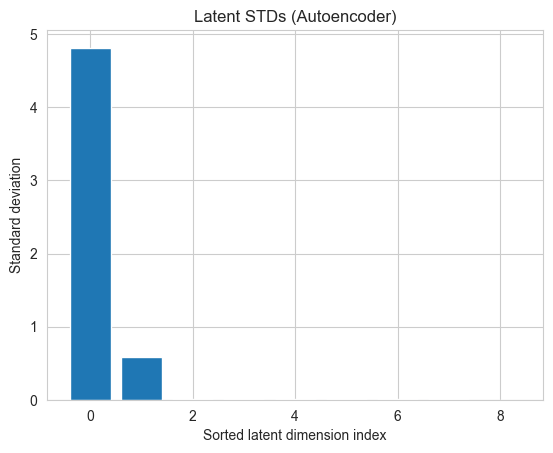

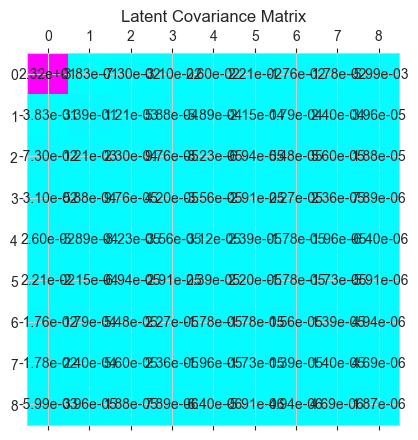

In [29]:

# ---- Plot 1: z0 vs z1 ----
plt.figure()
plt.scatter(z_np[:, idx[0]], z_np[:, idx[1]], s=10)
plt.gca().set_aspect('equal')
plt.xlabel(f'$z_{{{idx[0]}}}$')
plt.ylabel(f'$z_{{{idx[1]}}}$')
plt.title('Latent space: first two most active dims')
plt.show()


# Compute and sort latent STDs
z_std = z.std(0).detach().cpu().numpy()
idx = z.std(0).detach().cpu().argsort(descending=True)

# Plot
plt.figure()
plt.bar(np.arange(len(z_std)), z_std[idx])
plt.title('Latent STDs (Autoencoder)')
plt.xlabel('Sorted latent dimension index')
plt.ylabel('Standard deviation')
plt.show()


cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.2e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()

<Figure size 640x480 with 0 Axes>

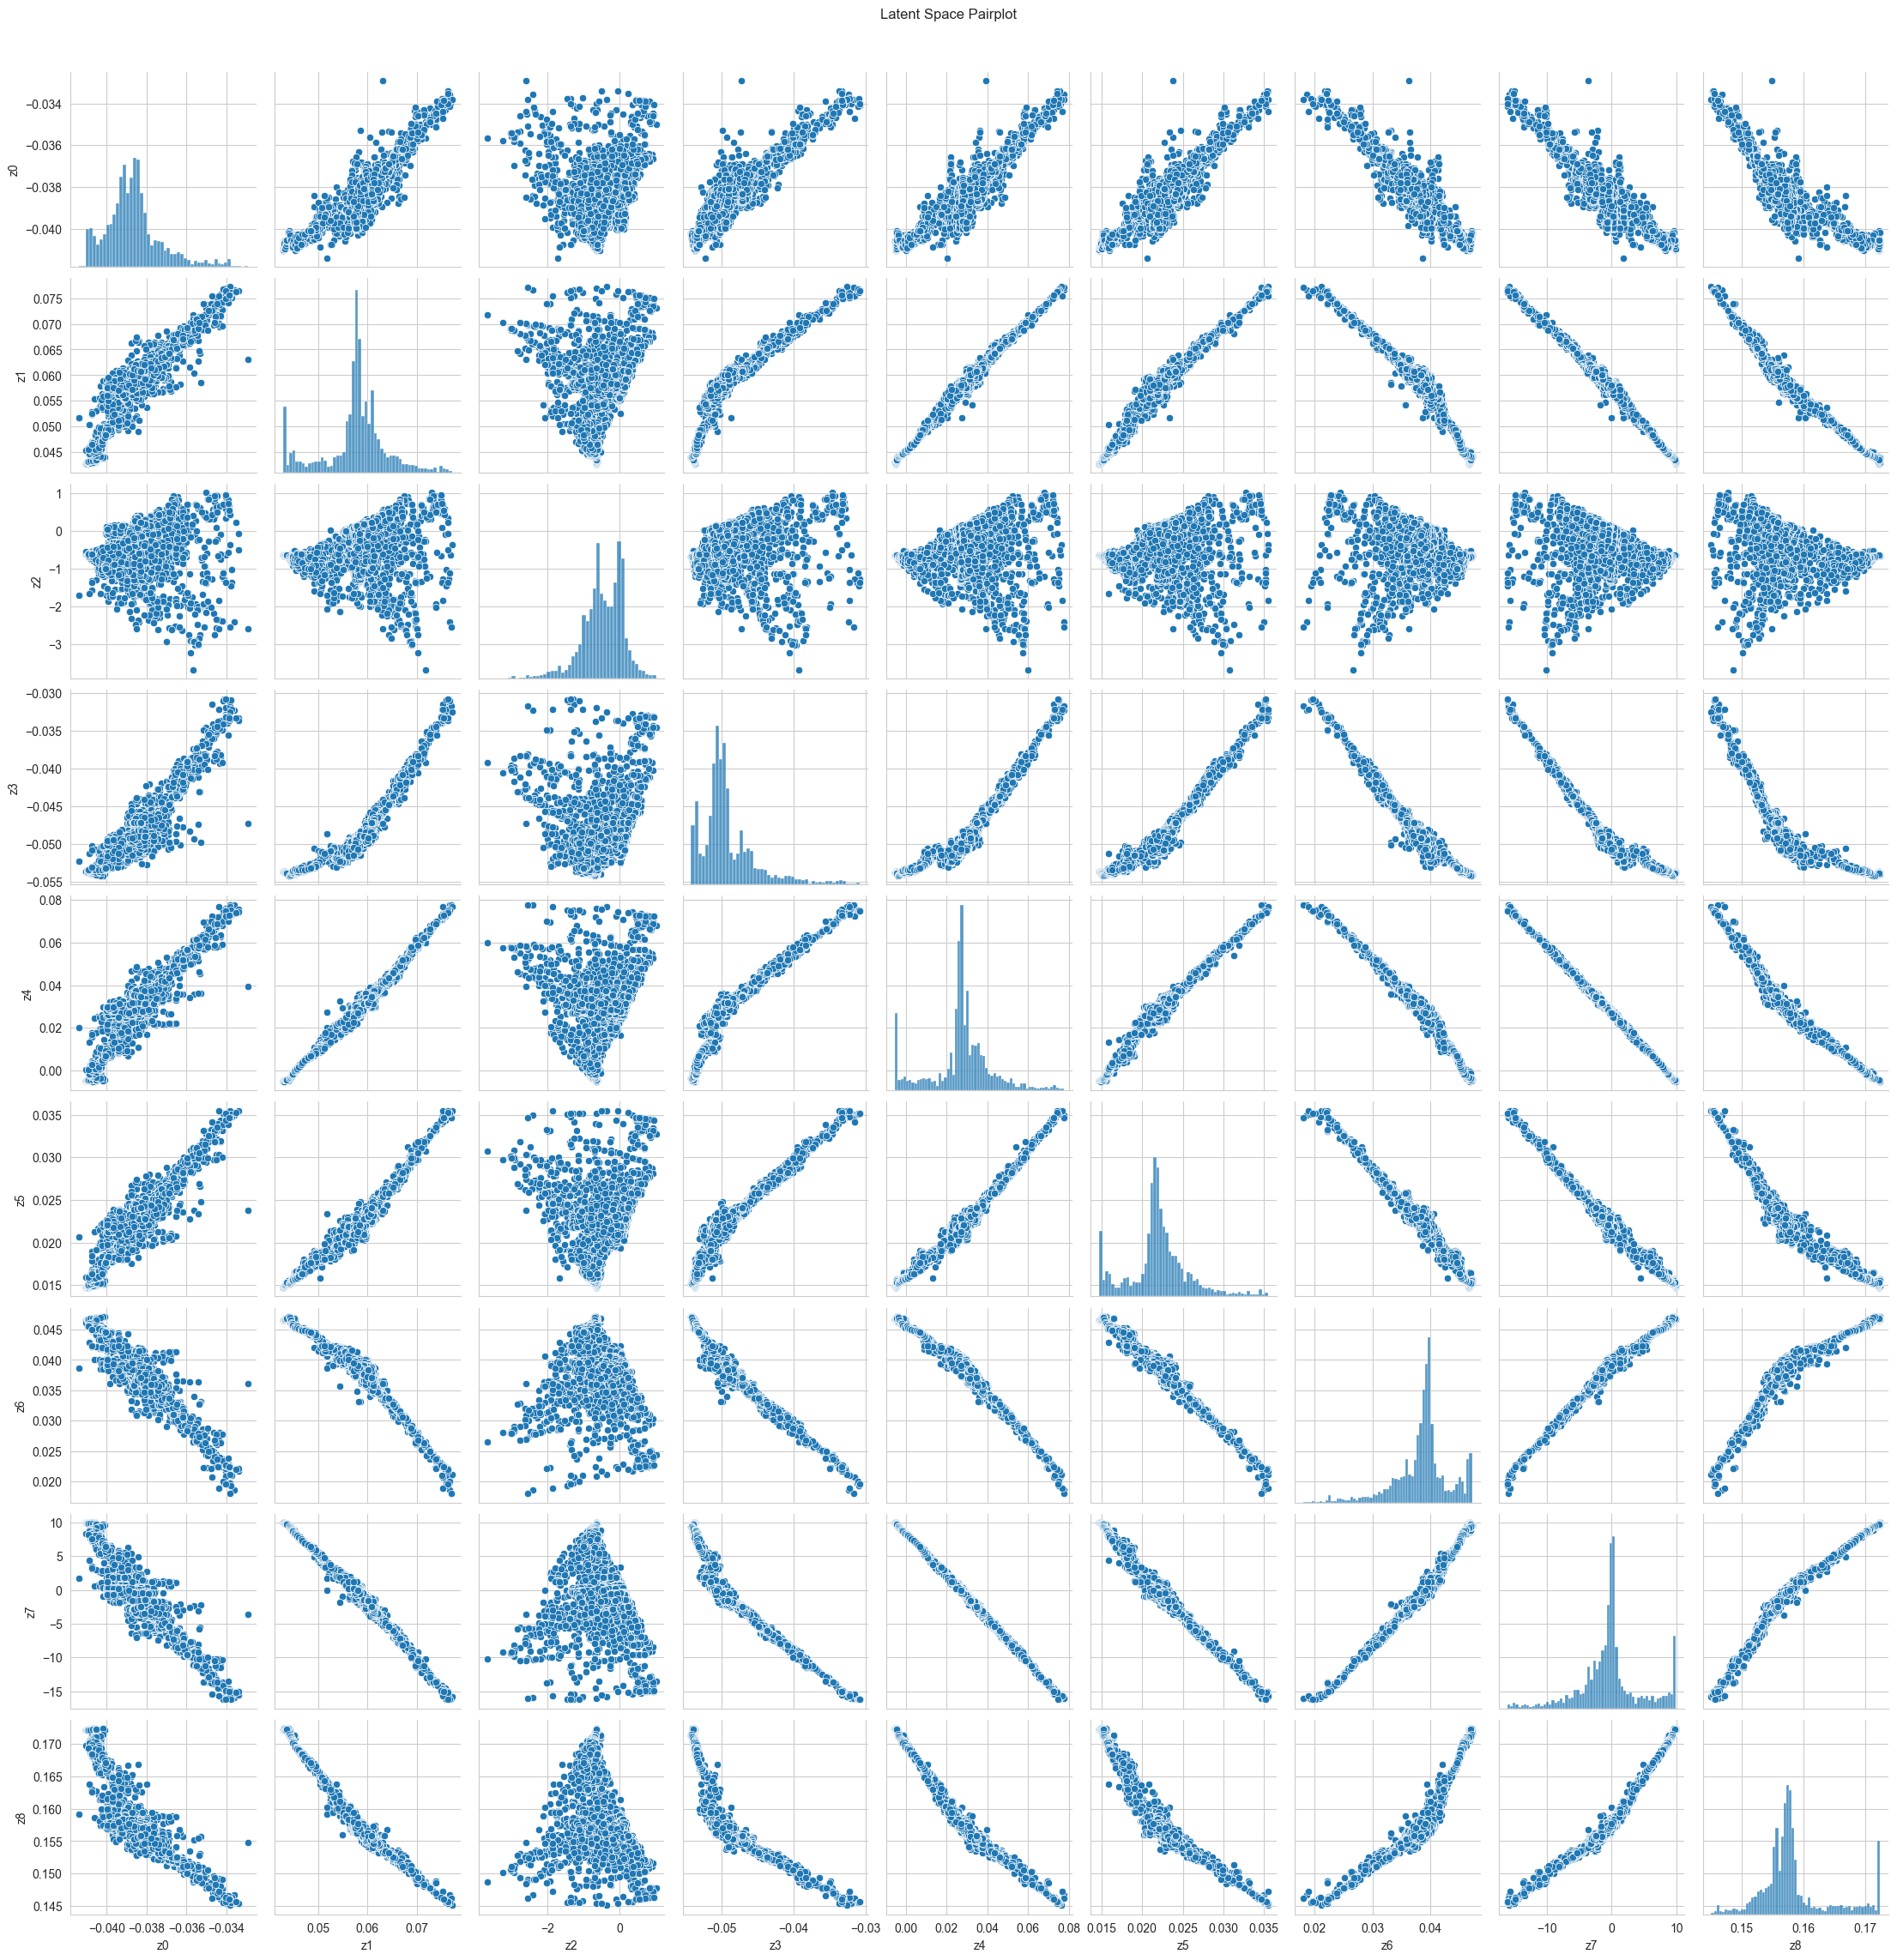

In [30]:
df_GLV = pd.DataFrame(z.cpu().detach().numpy(), columns=[f'z{i}' for i in range(z.shape[1])])
plt.figure()
sns.pairplot(df_GLV)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()

## Diffusion Maps

In [4]:
from pydiffmap import diffusion_map as dm
from sklearn.metrics import pairwise_distances

features = ['H2','O2', 'H2O', 'HO2', 'H2O2']
X_np = df[features].to_numpy()
idx = np.random.choice(X_np.shape[0], min(5000, X_np.shape[0]), replace=False)

D   = pairwise_distances(X_np[idx], X_np[idx])

eps = np.median(D)**2    # rough scale

neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
mydmap = dm.DiffusionMap.from_sklearn(
    n_evecs=2,
    k=50,
    epsilon=eps,
    alpha=1.0,
    neighbor_params=neighbor_params
)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(X_np)
print("Raw eigenvalues from pydiffmap:")
print(mydmap.evals)

Raw eigenvalues from pydiffmap:
[-2439.22041973 -6189.47156424]


In [9]:
from pydiffmap.visualization import embedding_plot, data_plot
import matplotlib.pyplot as plt
import numpy as np

# Safety: ensure internal data is ndarray
mydmap.data = np.asarray(mydmap.data)

# ---------------------------------------
# 1) Embedding plot (diffusion map space)
# ---------------------------------------
fig_emb = embedding_plot(
    mydmap,
    n_evecs=(1, 2),                 # ψ1 vs ψ2
    scatter_kwargs={'cmap': 'Spectral'},
    show=False                      # do not call plt.show() inside
)

ax_emb = fig_emb.axes[0]            # first (only) Axes
sc_emb = ax_emb.collections[0]      # the scatter created by embedding_plot
cb_emb = fig_emb.colorbar(sc_emb, ax=ax_emb)
cb_emb.set_label(r'$\psi_1$')       # what the colours represent

fig_emb.tight_layout()
plt.show()

# ---------------------------------------
# 2) Data plot (x–y–z space)
# ---------------------------------------
fig_data = data_plot(
    mydmap,
    n_evec=1,                       # colour by ψ1
    dim=3,
    scatter_kwargs={'cmap': 'Spectral'},
    show=False
)

ax_data = fig_data.axes[0]
sc_data = ax_data.collections[0]
cb_data = fig_data.colorbar(sc_data, ax=ax_data)
cb_data.set_label(r'$\psi_1$')

fig_data.tight_layout()
plt.show()





TypeError: embedding_plot() got an unexpected keyword argument 'n_evecs'

Correlation between H2 and \psi_1
[[ 1.         -0.93445246]
 [-0.93445246  1.        ]]
Correlation between O2 and \psi_2
[[1.         0.18585977]
 [0.18585977 1.        ]]


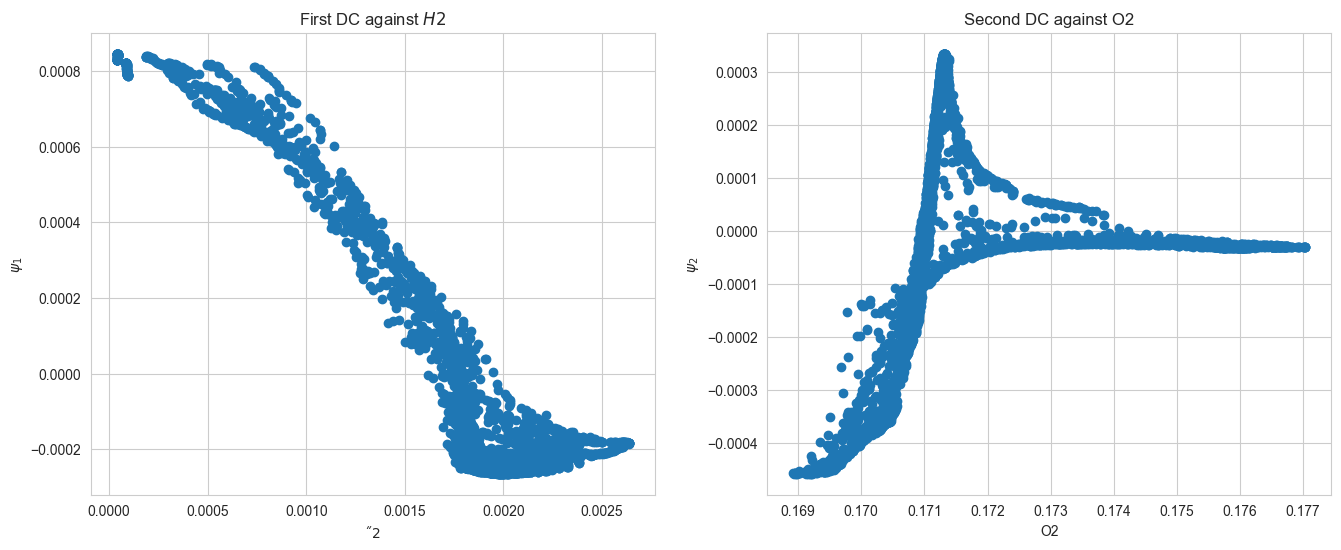

In [6]:
H2 = df['H2'].to_numpy()
O2   = df['O2'].to_numpy()

print('Correlation between H2 and \psi_1')
print(np.corrcoef(dmap[:,0], H2))

plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(H2, dmap[:,0])
ax.set_title('First DC against $H2$')
ax.set_xlabel(r'$\H2$')
ax.set_ylabel(r'$\psi_1$')
ax.axis('tight')

print('Correlation between O2 and \psi_2')
print(np.corrcoef(dmap[:,1], O2))

ax2 = plt.subplot(122)
ax2.scatter(O2, dmap[:,1])
ax2.set_title('Second DC against O2')
ax2.set_xlabel('O2')
ax2.set_ylabel(r'$\psi_2$')

plt.show()